In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import matplotlib as mpl
from matplotlib.colors import LogNorm
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from scipy import linalg
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, GridSearchCV
from sklearn.neural_network import MLPClassifier


In [2]:
#load the data
dataHeart = pd.read_csv('datasets/heart.csv')
dataWine = pd.read_csv('datasets/winequality-red.csv')
data = dataHeart
X_heart = data.iloc[:, :-1]
y_heart = data.iloc[:, -1:].values.ravel()

data = dataWine
X_wine = data.iloc[:, :-1]
y_wine = data.iloc[:, -1:].values.ravel()
y_wine = np.array(list(map(lambda x: 1 if x > 5 else 0, y_wine)))

Text(0.5, 1.0, 'Heart Disease t-SNE before Dimension Reduction')

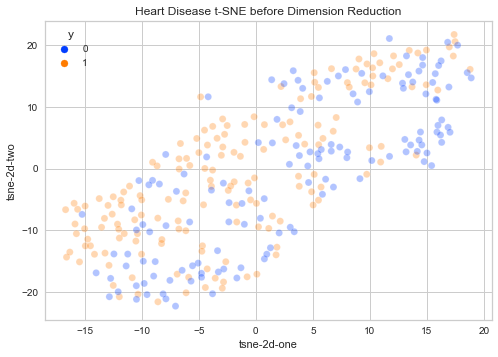

In [3]:
#using t-SNE to visualize data before dimension reduction - Heart Disease
tsne_results = TSNE(n_components=2).fit_transform(X_heart)
tsne_scatter = pd.DataFrame(np.array(tsne_results), columns=['tsne-2d-one', 'tsne-2d-two'])
tsne_scatter["y"] = y_heart
plt.figure()
sns.scatterplot(
    data=tsne_scatter,
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("bright", 2),
    legend="full",
    alpha=0.3
).set_title('Heart Disease t-SNE before Dimension Reduction')

Text(0.5, 1.0, 'Red Wine t-SNE before Dimension Reduction')

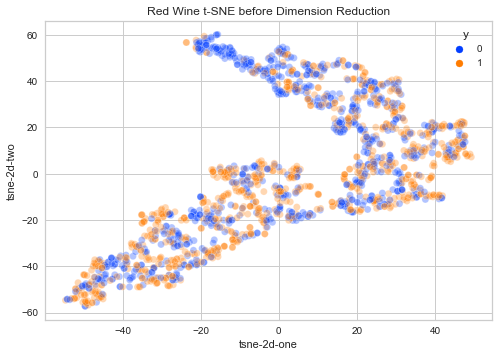

In [4]:
#using t-SNE to visualize data before dimension reduction - Red Wine
tsne_results = TSNE(n_components=2).fit_transform(X_wine)
tsne_scatter = pd.DataFrame(np.array(tsne_results), columns=['tsne-2d-one', 'tsne-2d-two'])
tsne_scatter["y"] = y_wine
plt.figure()
sns.scatterplot(
    data=tsne_scatter,
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("bright", 2),
    legend="full",
    alpha=0.3
).set_title('Red Wine t-SNE before Dimension Reduction')

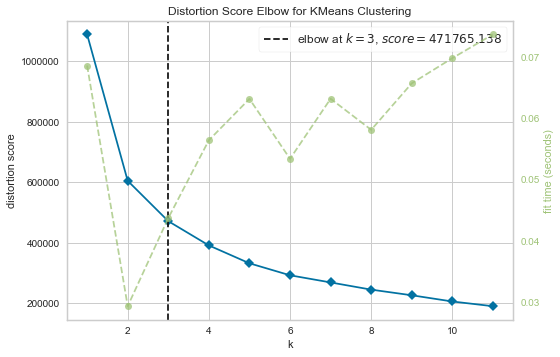

In [5]:
#using k elbow to determine k for heart disease data
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(X_heart)
visualizer.show()    

In [6]:
def clusterPerformance(X, y, name):
    random_state = 1
    k = np.arange(1,12)
    adjusted_rand = []
    mutual_info = []
    homogeneity = []
    completeness = []
    v_measure = []
    for i in k:
        kmeans = KMeans(n_clusters=i, random_state=random_state).fit(X)
        adjusted_rand.append(metrics.rand_score(kmeans.labels_, y))
        mutual_info.append(metrics.mutual_info_score(kmeans.labels_, y))
        homogeneity.append(metrics.homogeneity_score(kmeans.labels_, y))
        completeness.append(metrics.completeness_score(kmeans.labels_, y))
        v_measure.append(metrics.v_measure_score(kmeans.labels_, y))

    plt.plot(k, adjusted_rand, label = "adjusted_rand")
    plt.plot(k, mutual_info, label = "mutual_info")
    plt.plot(k, homogeneity, label = "homogeneity")
    plt.plot(k, completeness, label = "completeness")
    plt.plot(k, v_measure, label = "v_measure")

    plt.xlabel('number of clusters k')
    # Set the y axis label of the current axis.
    plt.ylabel('score value')
    # Set a title of the current axes.
    plt.title(name + ' cluster performance')
    # show a legend on the plot
    plt.legend()
    # Display a figure.
    plt.show()   

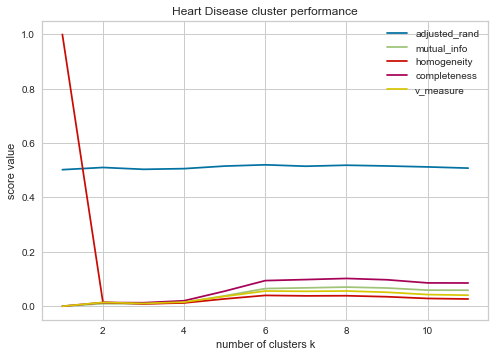

In [7]:
# cluster performance of heart disease
clusterPerformance(X_heart, y_heart, "Heart Disease")

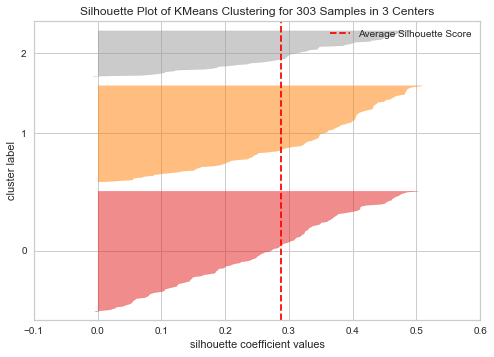

In [8]:
model = SilhouetteVisualizer(KMeans(3))
model.fit(X_heart)
model.show()

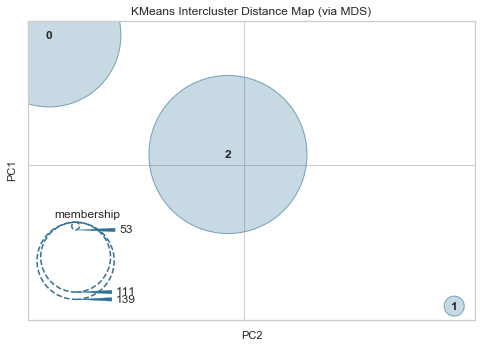

In [9]:
visualizer = InterclusterDistance(KMeans(3))
visualizer.fit(X_heart)        
visualizer.show()   

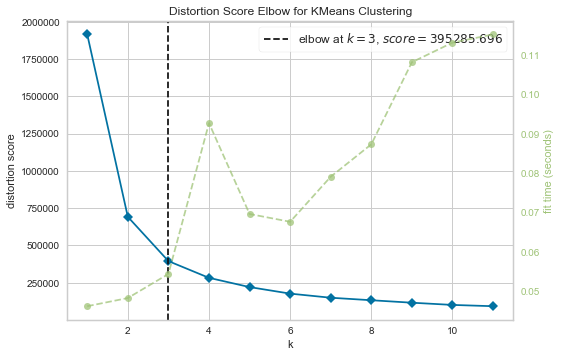

In [10]:
#using k elbow to determine k for red wine data
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(X_wine)
visualizer.show()    

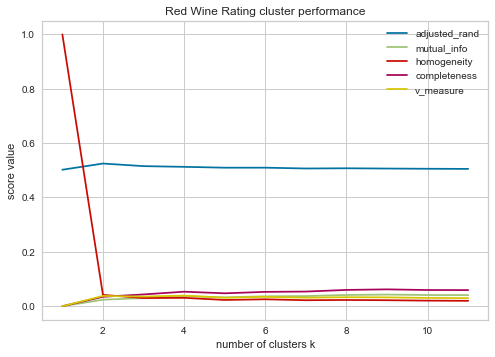

In [11]:
# cluster performance of red wine
clusterPerformance(X_wine, y_wine, "Red Wine Rating")

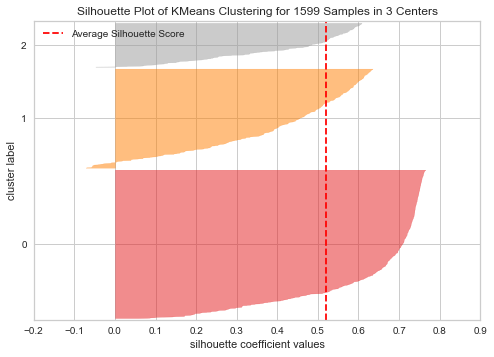

In [12]:
model = SilhouetteVisualizer(KMeans(3))
model.fit(X_wine)
model.show()

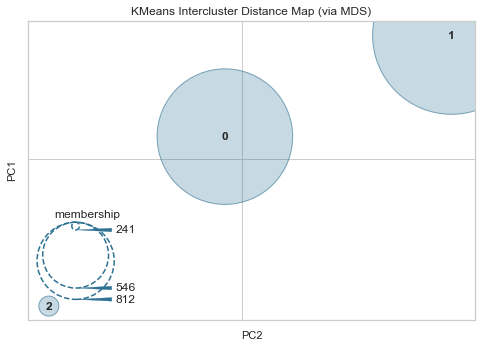

In [13]:
visualizer = InterclusterDistance(KMeans(3))
visualizer.fit(X_wine)        
visualizer.show()   

In [14]:
def find_best_n_components(X, name):
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 12)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(X)
            bic.append(gmm.bic(X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    bic = np.array(bic)
    color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                                  'darkorange'])
    clf = best_gmm
    bars = []

    # Plot the BIC scores
    spl = plt.subplot(1, 1, 1)
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + .2 * (i - 2)
        bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                      (i + 1) * len(n_components_range)],
                            width=.2, color=color))
    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title(name + ' BIC score per model')
    xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
        .2 * np.floor(bic.argmin() / len(n_components_range))
    plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
    spl.set_xlabel('Number of components')
    spl.legend([b[0] for b in bars], cv_types)

    plt.show()  

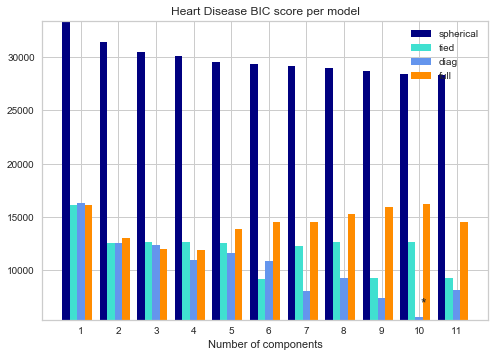

In [15]:
#Find the best number of components and covariance_type for EM
find_best_n_components(X_heart, "Heart Disease")

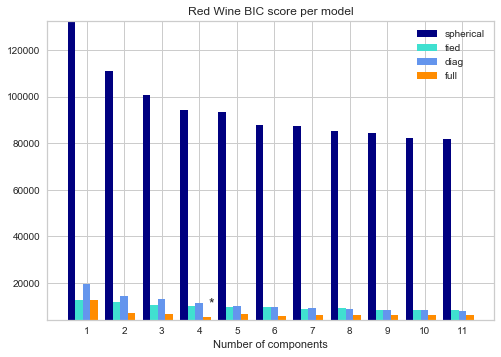

In [16]:
find_best_n_components(X_wine, "Red Wine")

In [17]:
def clusterPerformanceGM(X, y, name):
    random_state = 1
    k = np.arange(1,12)
    adjusted_rand = []
    ami = []
    mutual_info = []
    homogeneity = []
    completeness = []
    v_measure = []
    for i in k:
        gm = GaussianMixture(n_components=i, covariance_type='diag', random_state=1).fit_predict(X)
        adjusted_rand.append(metrics.rand_score(gm, y))
        mutual_info.append(metrics.mutual_info_score(gm, y))
        homogeneity.append(metrics.homogeneity_score(gm, y))
        completeness.append(metrics.completeness_score(gm, y))
        v_measure.append(metrics.v_measure_score(gm, y))

    plt.plot(k, adjusted_rand, label = "adjusted_rand")
    plt.plot(k, mutual_info, label = "mutual_info")
    plt.plot(k, homogeneity, label = "homogeneity")
    plt.plot(k, completeness, label = "completeness")
    plt.plot(k, v_measure, label = "v_measure")

    plt.xlabel('number of clusters k')
    # Set the y axis label of the current axis.
    plt.ylabel('score value')
    # Set a title of the current axes.
    plt.title(name + ' cluster performance')
    # show a legend on the plot
    plt.legend()
    # Display a figure.
    plt.show() 

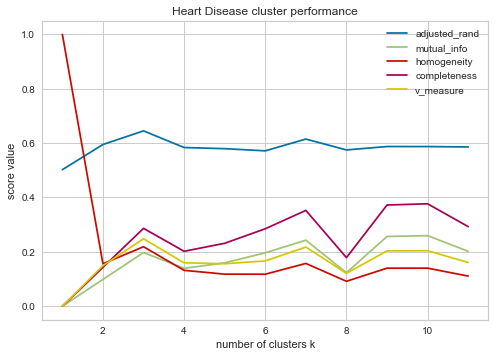

In [18]:
clusterPerformanceGM(X_heart, y_heart, "Heart Disease")

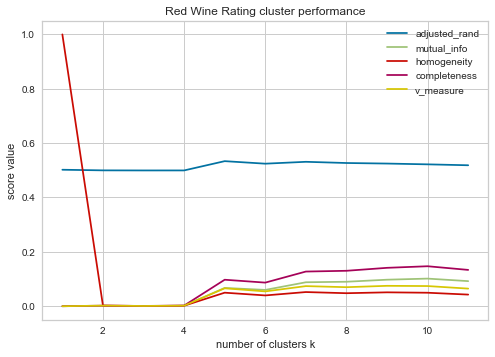

In [19]:
clusterPerformanceGM(X_wine, y_wine, "Red Wine Rating")

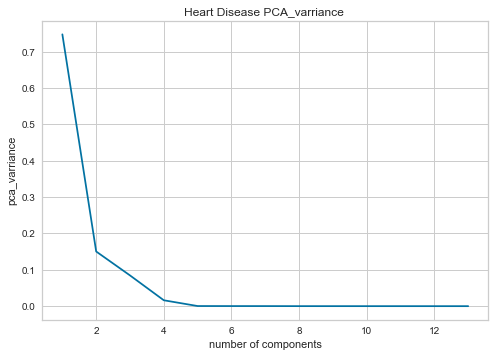

In [20]:
pca = PCA(n_components=13)
pca.fit(X_heart)
pca_varriance = pca.explained_variance_ratio_

components = np.arange(1,14)
plt.plot(components, pca_varriance, label = "pca_varriance")
plt.xlabel('number of components')
plt.ylabel('pca_varriance')
plt.title('Heart Disease PCA_varriance ')
plt.show() 


In [21]:
pca = PCA(n_components=3)
pca.fit(X_heart)
pca_X_heart = pca.transform(X_heart)
print(X_heart.shape)
print(pca_X_heart.shape)

(303, 13)
(303, 3)


In [22]:
#plot t-SNE
def plot_tsne(X, y, title):
    tsne_results = TSNE(n_components=2).fit_transform(X)
    tsne_scatter = pd.DataFrame(np.array(tsne_results), columns=['tsne-2d-one', 'tsne-2d-two'])
    tsne_scatter["y"] = y
    plt.figure()
    sns.scatterplot(
        data=tsne_scatter,
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("bright", 2),
        legend="full",
        alpha=0.3
    ).set_title(title)

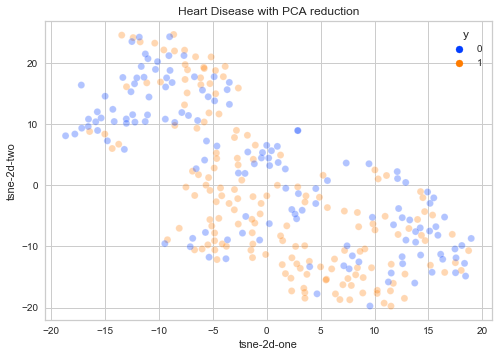

In [23]:
plot_tsne(pca_X_heart, y_heart, "Heart Disease with PCA reduction")

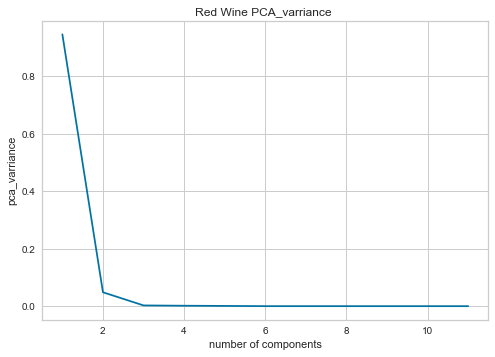

In [24]:
pca = PCA(n_components=11)
pca.fit(X_wine)
pca_varriance = pca.explained_variance_ratio_
components = np.arange(1,12)

plt.plot(components, pca_varriance, label = "pca_varriance")
plt.xlabel('number of components')
plt.ylabel('pca_varriance')
plt.title('Red Wine PCA_varriance ')
plt.show() 

In [25]:
pca = PCA(n_components=4)
pca.fit(X_wine)
pca_X_wine = pca.transform(X_wine)
print(X_wine.shape)
print(pca_X_wine.shape)

(1599, 11)
(1599, 4)


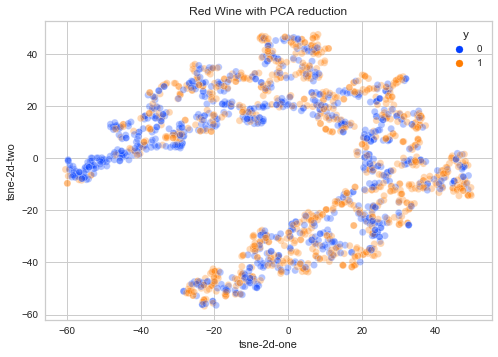

In [26]:
plot_tsne(pca_X_wine, y_wine, "Red Wine with PCA reduction")

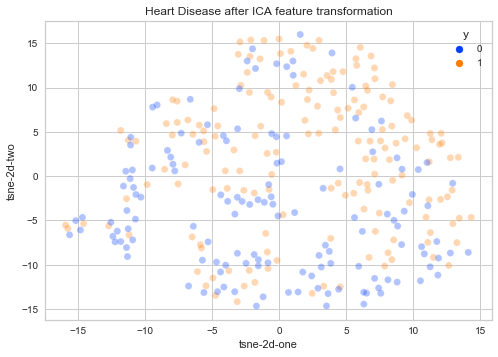

In [27]:
#ICA Heart
ica = FastICA(n_components=3)
ica_X_heart = ica.fit_transform(X_heart)
plot_tsne(ica_X_heart, y_heart, "Heart Disease after ICA feature transformation")

/Users/tpduong/opt/miniconda3/envs/ai_env/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


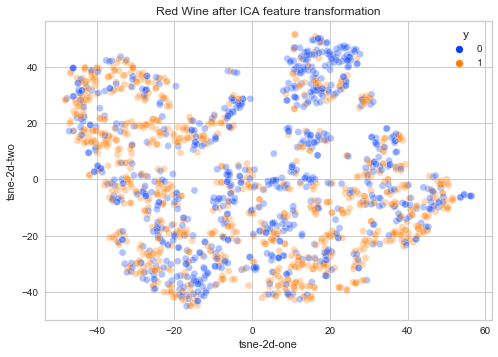

In [28]:

#ICA Wine
ica = FastICA(n_components=4)
ica_X_wine = ica.fit_transform(X_wine)
plot_tsne(ica_X_wine, y_wine, "Red Wine after ICA feature transformation")

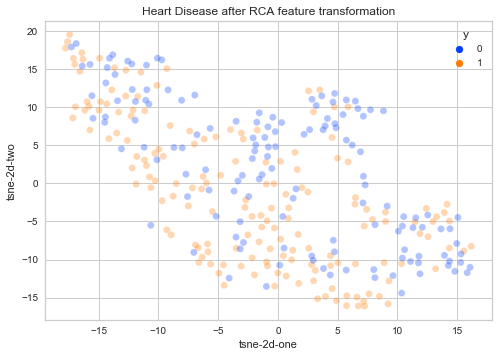

In [29]:
transformer = GaussianRandomProjection(3, random_state = 1)
X_rca_heart = transformer.fit_transform(X_heart)
plot_tsne(X_rca_heart, y_heart, "Heart Disease after RCA feature transformation")

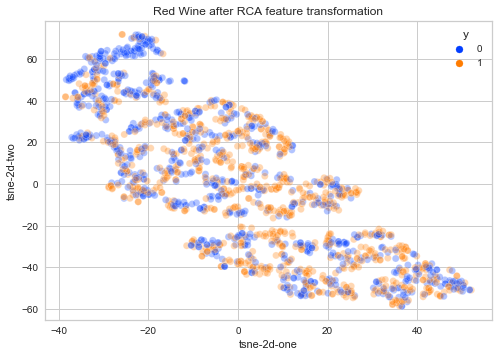

In [30]:
transformer = GaussianRandomProjection(4, random_state = 1)
X_rca_wine = transformer.fit_transform(X_wine)
plot_tsne(X_rca_wine, y_wine, "Red Wine after RCA feature transformation")

In [31]:
X_new = SelectKBest(chi2, k="all").fit(X_heart, y_heart)
X_new.scores_

array([ 23.28662399,   7.57683451,  62.59809791,  14.8239245 ,
        23.93639448,   0.20293368,   2.97827075, 188.32047169,
        38.91437697,  72.64425301,   9.8040952 ,  66.44076512,
         5.79185297])

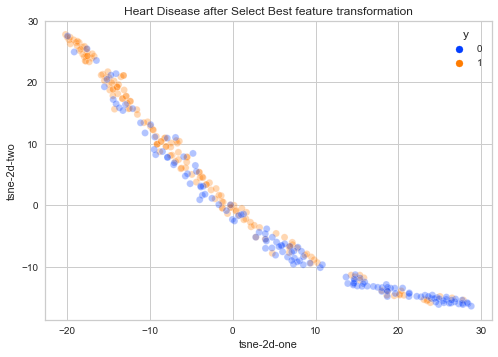

In [32]:
X_select_best_heart = SelectKBest(chi2, k=4).fit_transform(X_heart, y_heart)
plot_tsne(X_select_best_heart, y_heart, "Heart Disease after Select Best feature transformation")

In [33]:
X_new = SelectKBest(chi2, k="all").fit(X_wine, y_wine)
X_new.scores_

array([5.26525668e+00, 1.00297102e+01, 5.66670287e+00, 5.84022628e-03,
       4.85195914e-01, 4.20059068e+01, 2.00230590e+03, 1.44572025e-04,
       1.22551075e-04, 3.31761735e+00, 3.29086327e+01])

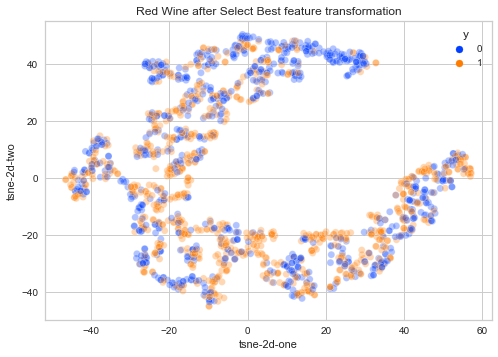

In [34]:
X_select_best_wine = SelectKBest(chi2, k=5).fit_transform(X_wine, y_wine)
plot_tsne(X_select_best_wine, y_wine, "Red Wine after Select Best feature transformation")

In [52]:
def getScores(predicted, actual):
    scores = []
    scores.append(round(metrics.rand_score(predicted, actual), 3))
    scores.append(round(metrics.mutual_info_score(predicted, actual), 3))
    scores.append(round(metrics.homogeneity_score(predicted, actual), 3))
    scores.append(round(metrics.completeness_score(predicted, actual), 3))
    scores.append(round(metrics.v_measure_score(predicted, actual), 3))
    print(scores)
    return scores

In [53]:
random_state = 1
kmeans = KMeans(n_clusters=3, random_state=random_state)
gm_heart = GaussianMixture(n_components=9, covariance_type='diag', random_state=random_state)
gm_wine = GaussianMixture(n_components=6, covariance_type='full', random_state=random_state)

scores = {}

kmeans.fit_predict(pca_X_heart)
scores["heart-kmeans-pca"] = getScores(kmeans.labels_, y_heart)
kmeans.fit_predict(ica_X_heart)
scores["heart-kmeans-ica"] = getScores(kmeans.labels_, y_heart)
kmeans.fit_predict(X_rca_heart)
scores["heart-kmeans-rca"] = getScores(kmeans.labels_, y_heart)
kmeans.fit_predict(X_select_best_heart)
scores["heart-kmeans-skb"] = getScores(kmeans.labels_, y_heart)

result = gm_heart.fit_predict(pca_X_heart)
scores["heart-gm-pca"] = getScores(result, y_heart)

result = gm_heart.fit_predict(ica_X_heart)
scores["heart-gm-ica"] = getScores(result, y_heart)

result = gm_heart.fit_predict(X_rca_heart)
scores["heart-gm-rca"] = getScores(result, y_heart)

result = gm_heart.fit_predict(X_select_best_heart)
scores["heart-gm-skb"] = getScores(result, y_heart)


kmeans.fit_predict(pca_X_wine)
scores["wine-kmeans-pca"] = getScores(kmeans.labels_, y_wine)
kmeans.fit_predict(ica_X_wine)
scores["wine-kmeans-ica"] = getScores(kmeans.labels_, y_wine)
kmeans.fit_predict(X_rca_wine)
scores["wine-kmeans-rca"] = getScores(kmeans.labels_, y_wine)
kmeans.fit_predict(X_select_best_wine)
scores["wine-kmeans-skb"] = getScores(kmeans.labels_, y_wine)

result = gm_wine.fit_predict(pca_X_wine)
scores["wine-gm-pca"] = getScores(result, y_wine)

result = gm_wine.fit_predict(ica_X_wine)
scores["wine-gm-ica"] = getScores(result, y_wine)

result = gm_wine.fit_predict(X_rca_wine)
scores["wine-gm-rca"] = getScores(result, y_wine)

result = gm_wine.fit_predict(X_select_best_wine)
scores["wine-gm-skb"] = getScores(result, y_wine)


print(scores)


[0.504, 0.009, 0.008, 0.013, 0.01]
[0.522, 0.034, 0.032, 0.049, 0.039]
[0.497, 0.0, 0.0, 0.001, 0.0]
[0.547, 0.084, 0.077, 0.121, 0.094]
[0.513, 0.058, 0.029, 0.084, 0.043]
[0.518, 0.089, 0.043, 0.128, 0.064]
[0.508, 0.047, 0.025, 0.068, 0.036]
[0.634, 0.244, 0.175, 0.353, 0.234]
[0.515, 0.029, 0.029, 0.043, 0.035]
[0.513, 0.031, 0.033, 0.046, 0.038]
[0.514, 0.027, 0.027, 0.039, 0.032]
[0.517, 0.031, 0.031, 0.045, 0.037]
[0.507, 0.031, 0.022, 0.045, 0.03]
[0.514, 0.04, 0.025, 0.057, 0.035]
[0.505, 0.017, 0.01, 0.024, 0.014]
[0.521, 0.064, 0.039, 0.093, 0.055]
{'heart-kmeans-pca': [0.504, 0.009, 0.008, 0.013, 0.01], 'heart-kmeans-ica': [0.522, 0.034, 0.032, 0.049, 0.039], 'heart-kmeans-rca': [0.497, 0.0, 0.0, 0.001, 0.0], 'heart-kmeans-skb': [0.547, 0.084, 0.077, 0.121, 0.094], 'heart-gm-pca': [0.513, 0.058, 0.029, 0.084, 0.043], 'heart-gm-ica': [0.518, 0.089, 0.043, 0.128, 0.064], 'heart-gm-rca': [0.508, 0.047, 0.025, 0.068, 0.036], 'heart-gm-skb': [0.634, 0.244, 0.175, 0.353, 0.234], 

'\ngm_heart.fit_predict(pca_X_heart)\nscores["heart-kmeans-pca"] = getScores(gm_heart, y_heart)\n\nheart-gm-ica = gm_heart.fit_predict(ica_X_heart)\nheart-gm-rca = gm_heart.fit_predict(rca_X_heart)\nheart-gm-skb = gm_heart.fit_predict(X_select_best_heart)\n\nscores["heart-gm-pca"] = getScores(heart-gm-pca, y_heart)\nscores["heart-gm-ica"] = getScores(heart-gm-ica, y_heart)\nscores["heart-gm-rca"] = getScores(heart-gm-rca, y_heart)\nscores["heart-gm-skb"] = getScores(heart-gm-skb, y_heart)\n\nscores\n\n\nscores["heart-gm-skb"] = getScores(gm_heart, y_heart)\ngm_heart.fit_predict(ica_X_heart)\nscores["heart-gm-skb"] = getScores(gm_heart, y_heart)\ngm_heart.fit_predict(rca_X_heart)\nscores["heart-gm-skb"] = getScores(gm_heart, y_heart)\ngm_heart.fit_predict(X_select_best_heart)\nscores["heart-gm-skb"] = getScores(gm_heart, y_heart)\n\n\nprint(scores)\n\n\n\nheart-gm-pca = gm_heart.fit_predict(pca_X_heart)\nheart-gm-ica = gm_heart.fit_predict(ica_X_heart)\nheart-gm-rca = gm_heart.fit_predi

In [42]:
gm = GaussianMixture(n_components=4, covariance_type='diag', random_state=1)

result = gm.fit_predict(X_heart)


print(result)



[2 0 0 0 3 0 0 0 2 0 0 0 0 2 1 0 0 0 0 0 0 2 0 2 2 0 2 0 1 2 0 0 0 0 2 1 1
 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 2 0 2 0 0 0 0 2 0 3
 0 0 2 2 2 2 0 0 0 2 0 1 0 2 0 0 2 3 0 1 0 3 0 2 0 2 0 0 0 2 0 0 2 3 0 0 3
 2 0 0 0 0 0 0 0 3 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 2 3 3 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 0 0 3 2 0 0 0 3 3 3 0 3 3 3 0 0 0 0
 0 3 3 0 0 3 3 0 3 0 3 0 2 3 0 0 3 3 2 0 3 3 0 0 3 0 3 0 3 3 3 0 3 0 3 0 3
 2 3 3 3 0 3 0 2 0 2 3 3 0 3 0 0 3 3 2 3 0 3 3 0 3 2 0 0 3 3 1 3 0 3 3 3 3
 2 3 0 3 3 3 3 3 0 3 3 0 0 0 0 3 0 0 0 1 3 3 3 2 0 3 3 0 0 3 3 0 0 3 0 3 3
 3 2 3 0 2 3 0]


In [56]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    print("plotting learning curve")
    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)

    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes.legend(loc="best")

    return plt

/Users/tpduong/opt/miniconda3/envs/ai_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


plotting learning curve
0.7425742574257426


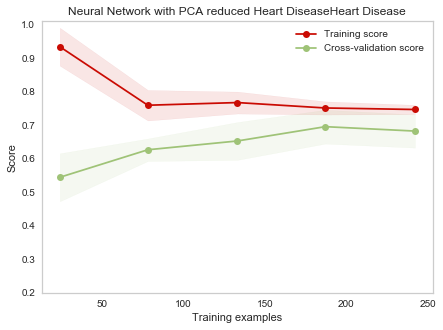

In [62]:

def makeModel(data, name):
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    clf = MLPClassifier()
    clf.fit(pca_X_heart, y_heart)
    fig, axes = plt.subplots(1, 1, figsize=(7, 5))
    title = "Neural Network with PCA reduced Heart Disease" + name
    plot_learning_curve(clf, title, pca_X_heart, y_heart, axes=axes, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

    print(clf.score(pca_X_heart, y_heart))


    plt.show()



makeModel(dataHeart, "Heart Disease")


/Users/tpduong/opt/miniconda3/envs/ai_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


plotting learning curve
0.6831683168316832


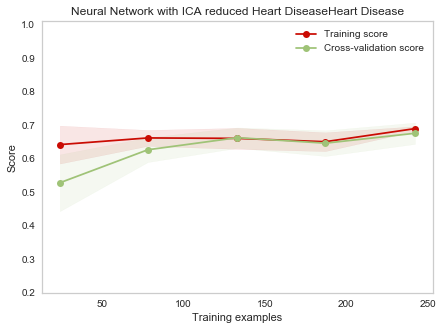

In [65]:
def makeModel(data, name):
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    clf = MLPClassifier()
    clf.fit(ica_X_heart, y_heart)
    fig, axes = plt.subplots(1, 1, figsize=(7, 5))
    title = "Neural Network with ICA reduced Heart Disease" + name
    plot_learning_curve(clf, title, ica_X_heart, y_heart, axes=axes, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

    print(clf.score(ica_X_heart, y_heart))


    plt.show()



makeModel(dataHeart, "Heart Disease")


plotting learning curve
0.6765676567656765


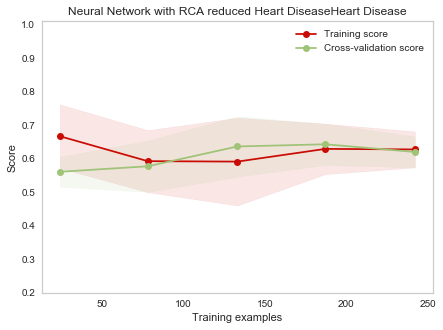

In [68]:
def makeModel(data, name):
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    clf = MLPClassifier()
    clf.fit(X_rca_heart, y_heart)
    fig, axes = plt.subplots(1, 1, figsize=(7, 5))
    title = "Neural Network with RCA reduced Heart Disease" + name
    plot_learning_curve(clf, title, X_rca_heart, y_heart, axes=axes, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

    print(clf.score(X_rca_heart, y_heart))


    plt.show()



makeModel(dataHeart, "Heart Disease")


plotting learning curve
0.8085808580858086


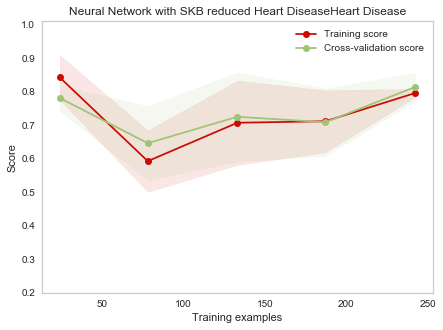

In [69]:
def makeModel(data, name):
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    clf = MLPClassifier()
    clf.fit(X_select_best_heart, y_heart)
    fig, axes = plt.subplots(1, 1, figsize=(7, 5))
    title = "Neural Network with SKB reduced Heart Disease" + name
    plot_learning_curve(clf, title, X_select_best_heart, y_heart, axes=axes, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

    print(clf.score(X_select_best_heart, y_heart))


    plt.show()



makeModel(dataHeart, "Heart Disease")
